The project follows a systematic approach:

• Import and preprocess the dataset, including handling missing values, standardizing numerical features, and encoding categorical variables.\
• Conduct exploratory data analysis (EDA) to understand data distribution and visualize patterns relevant to flight cancellations.\
• Perform feature engineering and split the dataset into training, validation, and test sets (80-10-10).\
• Establish baseline models with logistic regression and decision tree models to provide an initial benchmark for performance.\
• Apply advanced model training using more complex models to improve prediction accuracy.\
• Conduct hyperparameter tuning to optimize model parameters for the best performance.\
• Evaluate the optimized models on the test set to measure real-world prediction accuracy.\
• Analyze feature importance to interpret model results, identifying keyfactors affecting flight cancellations.\
• Compiling findings, methodologies, and future work for the final report.\

## Step-1: Import and preprocess the dataset

- Import the dataset.
- Handle missing values.

#### Importing the dataset.

In [2]:
# import all necessary libraries from requirements.txt
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
import datetime




In [2]:
import pandas as pd
import os

# Check the current working directory
print(os.getcwd())
!ls
# Print the full path before '/app'
full_path = os.getcwd()
print(full_path.split('/app')[0])
# Import the flights.csv file into a pandas DataFrame
df_flights = pd.read_csv('flight_dataset/flights.csv')
print(df_flights.head())

/app
docker-compose.yml  flights_cleaned.csv			  README.md
Dockerfile	    flights_cleaned_for_cancellation.csv  requirements.txt
flight_dataset	    project_notebook.ipynb



/tmp/ipykernel_307/2681771179.py:11: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  df_flights = pd.read_csv('flight_dataset/flights.csv')


KeyboardInterrupt: 

In [3]:
# Columns not needed or not typically needed
not_needed_columns = [
    "YEAR",            # All 2015
    "FLIGHT_NUMBER",   # Unique to each flight, doesn't generalize well for predictions.
    "TAIL_NUMBER",     # Unique identifier for aircraft, unlikely to contribute to predictions.
    "WHEELS_OFF",      # Redundant; its effect is captured in departure delay and time.
    "WHEELS_ON"        # Redundant; its effect is captured in arrival delay and time.
]
df_flights.drop(columns=not_needed_columns, inplace=True)

#### exploring the dataset types and columns and null values

In [21]:
def explore_the_df(df):
    print(df.shape)
    print(df.info())

    null_counts = df.isnull().sum()
    # Calculate the percentage of null values
    null_percentage = [(x / len(df) * 100) for x in null_counts]

    # Combine the counts and percentages into a single DataFrame
    null_summary = pd.DataFrame({'Null Count': null_counts, 'Percentage': null_percentage})
    print(null_summary)

In [20]:
explore_the_df(df_flights)


NameError: name 'explore_the_df' is not defined

EDA on cancellation reason

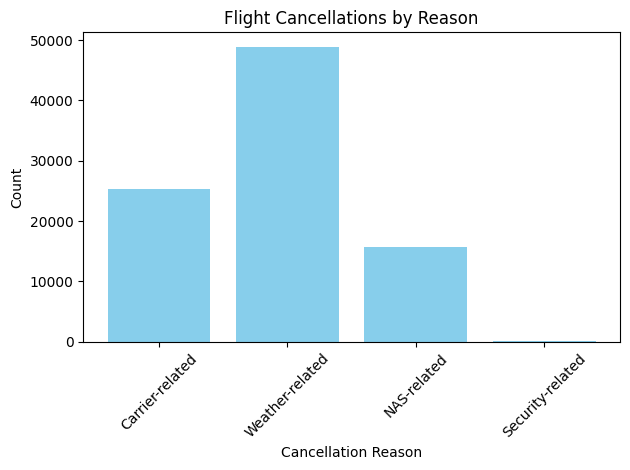

In [ ]:
import matplotlib.pyplot as plt

reason_counts = {"A": 25262, "B": 48851, "C": 15749, "D": 22}

# Mapping codes to full descriptions
reason_mapping = {
    "A": "Carrier-related",
    "B": "Weather-related",
    "C": "NAS-related",
    "D": "Security-related"
}

# Extract data for plotting
codes = list(reason_counts.keys())
counts = list(reason_counts.values())

# Replace codes with full descriptions for x-axis
descriptions = [reason_mapping[code] for code in codes]

# Plot the bar chart
plt.bar(descriptions, counts, color="skyblue")
plt.title("Flight Cancellations by Reason")
plt.xlabel("Cancellation Reason")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [9]:
print(df_flights["CANCELLED"].value_counts())
df_flights["CANCELLATION_REASON"].isnull().sum()

CANCELLED
0    5729195
1      89884
Name: count, dtype: int64


np.int64(5729195)

for cancelled flights, arrival delay is null, all kinds of delays are null, all 5 types of delay are all null. They have entries as number of minutes for other flights which has not been cancelled. 
So we are going to drop these columns.

As we want to predict cancellation reason, we will add not getting cancelled as another type of cancellation, with "N". So if our model predicts N, then the flight was not cancelled.


In [10]:
selected_columns = df_flights[df_flights["CANCELLED"] == 1]
print(selected_columns.shape)

for column in selected_columns.columns:
    print(f"{column}: {selected_columns[column].isnull().sum()}")

# selected_columns = df_flights[( df_flights["CANCELLED"] == 1)]
# print(selected_columns['AIR_SYSTEM_DELAY'].head(25))
# print(df_flights['CANCELLED'].value_counts())
# print(selected_columns['CANCELLED'].value_counts())
#AIR_SYSTEM_DELAY        = df_flights['AIR_SYSTEM_DELAY'].value_counts()

(89884, 26)
MONTH: 0
DAY: 0
DAY_OF_WEEK: 0
AIRLINE: 0
ORIGIN_AIRPORT: 0
DESTINATION_AIRPORT: 0
SCHEDULED_DEPARTURE: 0
DEPARTURE_TIME: 86153
DEPARTURE_DELAY: 86153
TAXI_OUT: 89047
SCHEDULED_TIME: 5
ELAPSED_TIME: 89884
AIR_TIME: 89884
DISTANCE: 0
TAXI_IN: 89884
SCHEDULED_ARRIVAL: 0
ARRIVAL_TIME: 89884
ARRIVAL_DELAY: 89884
DIVERTED: 0
CANCELLED: 0
CANCELLATION_REASON: 0
AIR_SYSTEM_DELAY: 89884
SECURITY_DELAY: 89884
AIRLINE_DELAY: 89884
LATE_AIRCRAFT_DELAY: 89884
WEATHER_DELAY: 89884


In [22]:
# List of columns to drop
columns_to_drop = ['CANCELLED','ARRIVAL_TIME', 'ARRIVAL_DELAY', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']

# Drop the columns from the dataframe
df_flights2 = df_flights.drop(columns=columns_to_drop)


Now we will replace rest of the null values with 0, since we cannot drop those rows.

In [23]:
# Drop rows with any null values from df_flights2
df_flights2["CANCELLATION_REASON"].fillna("N", inplace=True)
print(df_flights2.isnull().sum())
print(df_flights2["CANCELLATION_REASON"].value_counts())


/tmp/ipykernel_107/711136703.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_flights2["CANCELLATION_REASON"].fillna("N", inplace=True)


MONTH                       0
DAY                         0
DAY_OF_WEEK                 0
AIRLINE                     0
ORIGIN_AIRPORT              0
DESTINATION_AIRPORT         0
SCHEDULED_DEPARTURE         0
DEPARTURE_TIME          86153
DEPARTURE_DELAY         86153
TAXI_OUT                89047
SCHEDULED_TIME              6
ELAPSED_TIME           105071
AIR_TIME               105071
DISTANCE                    0
TAXI_IN                 92513
SCHEDULED_ARRIVAL           0
DIVERTED                    0
CANCELLATION_REASON         0
dtype: int64
CANCELLATION_REASON
N    5729195
B      48851
A      25262
C      15749
D         22
Name: count, dtype: int64


In [25]:
df_flights3 = df_flights2.fillna(0)
explore_the_df(df_flights3)

(5819079, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 18 columns):
 #   Column               Dtype  
---  ------               -----  
 0   MONTH                int64  
 1   DAY                  int64  
 2   DAY_OF_WEEK          int64  
 3   AIRLINE              object 
 4   ORIGIN_AIRPORT       object 
 5   DESTINATION_AIRPORT  object 
 6   SCHEDULED_DEPARTURE  int64  
 7   DEPARTURE_TIME       float64
 8   DEPARTURE_DELAY      float64
 9   TAXI_OUT             float64
 10  SCHEDULED_TIME       float64
 11  ELAPSED_TIME         float64
 12  AIR_TIME             float64
 13  DISTANCE             int64  
 14  TAXI_IN              float64
 15  SCHEDULED_ARRIVAL    int64  
 16  DIVERTED             int64  
 17  CANCELLATION_REASON  object 
dtypes: float64(7), int64(7), object(4)
memory usage: 799.1+ MB
None
                     Null Count  Percentage
MONTH                         0         0.0
DAY                           0     

In [29]:
df_flights3.to_csv('flight_dataset/flights_cleaned_for_cancellation.csv', index=False)

PermissionError: [Errno 13] Permission denied: 'flight_dataset/flights_cleaned_for_cancellation.csv'

## Step-2: make changes to columns, encode, standardize and add engineered columns.


loading the cleaned df from a csv file

In [3]:
df_cleaned = pd.read_csv('flights_cleaned_for_cancellation.csv')
print(df_cleaned.head())

/tmp/ipykernel_882/734130425.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_cleaned = pd.read_csv('flights_cleaned_for_cancellation.csv')


   MONTH  DAY  DAY_OF_WEEK AIRLINE ORIGIN_AIRPORT DESTINATION_AIRPORT  \
0      1    1            4      AS            ANC                 SEA   
1      1    1            4      AA            LAX                 PBI   
2      1    1            4      US            SFO                 CLT   
3      1    1            4      AA            LAX                 MIA   
4      1    1            4      AS            SEA                 ANC   

   SCHEDULED_DEPARTURE  DEPARTURE_TIME  DEPARTURE_DELAY  TAXI_OUT  \
0                    5          2354.0            -11.0      21.0   
1                   10             2.0             -8.0      12.0   
2                   20            18.0             -2.0      16.0   
3                   20            15.0             -5.0      15.0   
4                   25            24.0             -1.0      11.0   

   SCHEDULED_TIME  ELAPSED_TIME  AIR_TIME  DISTANCE  TAXI_IN  \
0           205.0         194.0     169.0      1448      4.0   
1           280.0 

In [4]:
# Columns with integer data type
int_columns = ["MONTH", "DAY", "DAY_OF_WEEK", "SCHEDULED_DEPARTURE_HOUR", "SCHEDULED_DEPARTURE_MINUTE", "DEPARTURE_TIME_HOUR", "DEPARTURE_TIME_MINUTE", "DISTANCE", "SCHEDULED_ARRIVAL", "DIVERTED"]
# Columns with float data type
float_columns = ["DEPARTURE_DELAY", "TAXI_OUT", "SCHEDULED_TIME", "ELAPSED_TIME", "AIR_TIME", "TAXI_IN"]
# Columns with object data type
object_columns = ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT", "CANCELLATION_REASON"]

Now, I will convert all object columns to string datatype and then check if new null value appears

In [5]:
# Convert all object columns to string datatype
df_cleaned[object_columns] = df_cleaned[object_columns].astype(str)

Transform Time Columns
Split SCHEDULED_DEPARTURE and DEPARTURE_TIME into hour and minute components for better analysis.

In [6]:
df_cleaned["SCHEDULED_DEPARTURE_HOUR"] = df_cleaned["SCHEDULED_DEPARTURE"] // 100
df_cleaned["SCHEDULED_DEPARTURE_MINUTE"] = df_cleaned["SCHEDULED_DEPARTURE"] % 100
df_cleaned.drop("SCHEDULED_DEPARTURE", axis=1, inplace=True)

df_cleaned["DEPARTURE_TIME_HOUR"] = df_cleaned["DEPARTURE_TIME"] // 100
df_cleaned["DEPARTURE_TIME_MINUTE"] = df_cleaned["DEPARTURE_TIME"] % 100
df_cleaned.drop("DEPARTURE_TIME", axis=1, inplace=True)
df_cleaned.head(-10)

,MONTH,DAY,DAY_OF_WEEK,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,TAXI_OUT,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,TAXI_IN,SCHEDULED_ARRIVAL,DIVERTED,CANCELLATION_REASON,SCHEDULED_DEPARTURE_HOUR,SCHEDULED_DEPARTURE_MINUTE,DEPARTURE_TIME_HOUR,DEPARTURE_TIME_MINUTE
0,1,1,4,AS,ANC,SEA,-11.0,21.0,205.0,194.0,169.0,1448,4.0,430,0,N,0,5,23.0,54.0
1,1,1,4,AA,LAX,PBI,-8.0,12.0,280.0,279.0,263.0,2330,4.0,750,0,N,0,10,0.0,2.0
2,1,1,4,US,SFO,CLT,-2.0,16.0,286.0,293.0,266.0,2296,11.0,806,0,N,0,20,0.0,18.0
3,1,1,4,AA,LAX,MIA,-5.0,15.0,285.0,281.0,258.0,2342,8.0,805,0,N,0,20,0.0,15.0
4,1,1,4,AS,SEA,ANC,-1.0,11.0,235.0,215.0,199.0,1448,5.0,320,0,N,0,25,0.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5819064,12,31,4,UA,LAS,IAD,-3.0,15.0,262.0,236.0,203.0,2065,18.0,721,0,N,23,59,23.0,56.0
5819065,12,31,4,UA,PDX,IAH,-7.0,10.0,245.0,233.0,214.0,1825,9.0,604,0,N,23,59,23.0,52.0
5819066,12,31,4,UA,LAS,EWR,-2.0,15.0,283.0,261.0,231.0,2227,15.0,742,0,N,23,59,23.0,57.0
5819067,12,31,4,AA,DEN,MIA,-8.0,18.0,224.0,214.0,190.0,1709,6.0,543,0,N,23,59,23.0,51.0


In [7]:
df_cleaned["DEPARTURE_TIME_HOUR"] = df_cleaned["DEPARTURE_TIME_HOUR"].astype(int)
df_cleaned["DEPARTURE_TIME_MINUTE"] = df_cleaned["DEPARTURE_TIME_MINUTE"].astype(int)

Perform one-hot encoding for categorical variables:

In [8]:
df_cleaned.dtypes

MONTH                           int64
DAY                             int64
DAY_OF_WEEK                     int64
AIRLINE                        object
ORIGIN_AIRPORT                 object
DESTINATION_AIRPORT            object
DEPARTURE_DELAY               float64
TAXI_OUT                      float64
SCHEDULED_TIME                float64
ELAPSED_TIME                  float64
AIR_TIME                      float64
DISTANCE                        int64
TAXI_IN                       float64
SCHEDULED_ARRIVAL               int64
DIVERTED                        int64
CANCELLATION_REASON            object
SCHEDULED_DEPARTURE_HOUR        int64
SCHEDULED_DEPARTURE_MINUTE      int64
DEPARTURE_TIME_HOUR             int64
DEPARTURE_TIME_MINUTE           int64
dtype: object

In [8]:
categorical_columns = ["AIRLINE", "ORIGIN_AIRPORT", "DESTINATION_AIRPORT"]
for column in categorical_columns:
    df_cleaned[column] = df_cleaned[column].astype("category")
print(df_cleaned.dtypes)
df_cleaned = pd.get_dummies(df_cleaned, columns=categorical_columns, drop_first=True)


MONTH                            int64
DAY                              int64
DAY_OF_WEEK                      int64
AIRLINE                       category
ORIGIN_AIRPORT                category
DESTINATION_AIRPORT           category
DEPARTURE_DELAY                float64
TAXI_OUT                       float64
SCHEDULED_TIME                 float64
ELAPSED_TIME                   float64
AIR_TIME                       float64
DISTANCE                         int64
TAXI_IN                        float64
SCHEDULED_ARRIVAL                int64
DIVERTED                         int64
CANCELLATION_REASON             object
SCHEDULED_DEPARTURE_HOUR         int64
SCHEDULED_DEPARTURE_MINUTE       int64
DEPARTURE_TIME_HOUR              int64
DEPARTURE_TIME_MINUTE            int64
dtype: object


: 

: 

: 

Normalize continuous features using StandardScaler to ensure proper scaling

In [14]:
numerical_columns = ["DEPARTURE_DELAY", "TAXI_OUT", "SCHEDULED_TIME", 
                     "ELAPSED_TIME", "AIR_TIME", "DISTANCE", "TAXI_IN"]

scaler = StandardScaler()
df_cleaned[numerical_columns] = scaler.fit_transform(df_cleaned[numerical_columns])


Creating Engineered Features

In [15]:
df_cleaned["DURATION_VARIANCE"] = df_cleaned["SCHEDULED_TIME"] - df_cleaned["ELAPSED_TIME"]
df_cleaned["IS_PEAK_HOUR"] = df_cleaned["SCHEDULED_DEPARTURE_HOUR"].apply(lambda x: 1 if 6 <= x <= 9 or 16 <= x <= 19 else 0)
df_cleaned["IS_DELAYED"] = df_cleaned["DEPARTURE_DELAY"].apply(lambda x: 1 if x > 0 else 0)

Adding a new feature, is_holiday 

In [ ]:
# List of holidays in 2015 (MONTH, DAY)
holidays_2015 = [
    datetime.date(2015, 1, 1),   # New Year's Day
    datetime.date(2015, 1, 19),  # Martin Luther King Jr. Day
    datetime.date(2015, 2, 16),  # Presidents' Day
    datetime.date(2015, 5, 25),  # Memorial Day
    datetime.date(2015, 7, 3),   # Independence Day (observed)
    datetime.date(2015, 9, 7),   # Labor Day
    datetime.date(2015, 10, 12), # Columbus Day
    datetime.date(2015, 11, 11), # Veterans Day
    datetime.date(2015, 11, 26), # Thanksgiving Day
    datetime.date(2015, 12, 25)  # Christmas Day
]

# Create a new column with the date
df_cleaned["DATE"] = df_cleaned.apply(lambda row: datetime.date(2015, row["MONTH"], row["DAY"]), axis=1)

# Check if the date is in the list of holidays
df_cleaned["is_holiday"] = df_cleaned["DATE"].apply(lambda x: 1 if x in holidays_2015 else 0)

# Drop the DATE column
df_cleaned.drop("DATE", axis=1, inplace=True)

Encoding the target variable

In [23]:
# Encode target variable
label_encoder = LabelEncoder()
df_cleaned["CANCELLATION_REASON_ENCODED"] = label_encoder.fit_transform(df_cleaned["CANCELLATION_REASON"])

# Map the labels for reference
class_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Class Mapping:", class_mapping)


KeyError: 'CANCELLATION_REASON'

In [22]:
df_cleaned.drop("CANCELLATION_REASON", axis=1, inplace=True)
explore_the_df(df_cleaned)

(5819079, 24)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 24 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   MONTH                        int64  
 1   DAY                          int64  
 2   DAY_OF_WEEK                  int64  
 3   AIRLINE                      object 
 4   ORIGIN_AIRPORT               object 
 5   DESTINATION_AIRPORT          object 
 6   DEPARTURE_DELAY              float64
 7   TAXI_OUT                     float64
 8   SCHEDULED_TIME               float64
 9   ELAPSED_TIME                 float64
 10  AIR_TIME                     float64
 11  DISTANCE                     float64
 12  TAXI_IN                      float64
 13  SCHEDULED_ARRIVAL            int64  
 14  DIVERTED                     int64  
 15  SCHEDULED_DEPARTURE_HOUR     int64  
 16  SCHEDULED_DEPARTURE_MINUTE   int64  
 17  DEPARTURE_TIME_HOUR          int64  
 18  DEPARTURE_TIME_MINUTE       